# NEON Paper Plots (Soil Moisture)
## Figure 8: Soil Moisture Plots 
##### Author : Negin Sobhani negins@ucar.edu [@negin513](https://github.com/negin513)

##### Last revised: 2022-11-06
_______

## Creating Soil Moisture Time-Series Plots for ABBY

This notebooks have the scripts for:

1. Reading Evaluation (NEON) and model (CTSM) soilmoisture data for all neon sites and match layers
2. Creating Soil Moisture Time-Series Plots for ABBY at different depths

## Imports:

In [1]:
import os
import sys
import time

import numpy as np
import pandas as pd
import xarray as xr

from glob import glob
from os.path import join, expanduser

import matplotlib
import matplotlib.pyplot as plt

from scipy import stats
import tqdm
from neon_utils import download_eval_files
import matplotlib.colors as colors


In [2]:
print('xarray '+xr.__version__) ##-- was working with 0.20.0

xarray 0.20.2


## Dask Cluster

In [3]:
from distributed import Client
from ncar_jobqueue import NCARCluster

cluster = NCARCluster()
cluster.scale(16)
client = Client(cluster)
client

/glade/u/apps/opt/conda/envs/npl/lib/python3.7/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile
/glade/u/apps/opt/conda/envs/npl/lib/python3.7/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 37513 instead
  f"Port {expected} is already in use.\n"


Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/wwieder/tiff2nc/proxy/37513/status,
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/wwieder/tiff2nc/proxy/37513/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.12.206.48:38069,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/wwieder/tiff2nc/proxy/37513/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [4]:
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

def simple_tseries ( df_daily, plot_var, ax,neon_site, plot_dir,  save_switch=False):
    df_daily.plot ( x= 'time', y = plot_var , marker = 'o' ,ax =ax , color = '#e28743',label="NEON")
    df_daily.plot ( x= 'time', y = 'sim_'+plot_var , marker = '^' ,ax =ax , color = '#1d657e',label="CTSM")

    ax.set_xlabel('Time', fontsize=17)
    ax.set_ylabel(plot_var_desc+" ["+plot_var_unit+"]", fontsize=17)
    ax.set_title("2018-2020"+" "+neon_site, fontweight='bold',fontsize=17)

    if save_switch:
        plot_name = neon_site+'_'+year+'_'+plot_var+'_'+'tseries.png'
        plot_dir = os.path.join(plot_dir, plot_var)
        if not os.path.isdir(plot_dir):
            os.mkdir(plot_dir)
        #plt.savefig (os.path.join(plot_dir,plot_name), dpi=300,bbox_inches='tight')
    else:
        plt.show()

        
def simple_tseries_new ( df_daily, plot_var, ax,neon_site, plot_dir,  save_switch=False):
    #df_daily.plot ( x= 'time', y = plot_var , marker = 'o' ,ax =ax , color = '#8ECA94',label="NEON")
    #darkgreen
    #df_daily.plot ( x= 'time', y = plot_var , marker = 'o' ,ax =ax , color = 'darkgreen',label="NEON", alpha=0.9)
    #darkblue
    df_daily.plot ( x= 'time', y = plot_var , marker = 'o' ,ax =ax , color = '#1d657e',label="NEON", alpha=0.9)

    #lightblue
    #df_daily.plot ( x= 'time', y = 'sim_'+plot_var ,marker = 's', linestyle ='dashed' ,ax =ax , color = '#5BC2D3',label="CTSM", alpha=0.9)
    #orange
    df_daily.plot ( x= 'time', y = 'sim_'+plot_var , marker = 's', linestyle ='dashed' ,ax =ax , color = '#FFC20A',label="CTSM", alpha=0.9)
    #df_daily.plot ( x= 'time', y = 'sim_'+plot_var , marker = 's', linestyle ='dashed' ,ax =ax , color = '#ffb866',label="CTSM", alpha=0.9)

    #ax.set_xlabel('Time', fontsize=17)
    ax.set_ylabel(plot_var_desc+" ["+plot_var_unit+"]", fontsize=17)
    #ax.set_title("2018-2020"+" "+neon_site, fontweight='bold',fontsize=17)

    if save_switch:
        plot_name = neon_site+'_'+year+'_'+plot_var+'_'+'tseries.png'
        plot_dir = os.path.join(plot_dir, plot_var)
        #if not os.path.isdir(plot_dir):
            #os.mkdir(plot_dir)
        #plt.savefig (os.path.join(plot_dir,plot_name), dpi=300,bbox_inches='tight')
    else:
        plt.show()
        
        
def shaded_tseries ( df_daily, df_daily_std, plot_var, plot_dir,  save_switch=True):
    plt.plot ( df_daily.time, df_daily[plot_var], marker = 'o' , color = 'b',label="NEON")
    plt.plot ( df_daily.time, df_daily[sim_var], marker = 'o' , color = 'r',label="CLM")

    plt.fill_between(df_daily.time, df_daily[plot_var]-df_daily_std[plot_var], df_daily[plot_var]+df_daily_std[plot_var] ,alpha=0.1, color = 'b')
    plt.fill_between(df_daily.time, df_daily[sim_var]-df_daily_std[sim_var], df_daily[sim_var]+df_daily_std[sim_var] ,alpha=0.1, color = 'r')

    plt.legend()
    ax.set_xlabel('Time', fontsize=17)
    ax.set_ylabel(plot_var_desc+" ["+plot_var_unit+"]", fontsize=17)
    ax.set_title(year+" "+neon_site, fontweight='bold',fontsize=17)


    

    if save_switch:
        plot_name = neon_site+'_'+year+'_'+plot_var+'_'+'tseries_std.png'
        plot_dir = os.path.join(plot_dir, plot_var)
        if not os.path.isdir(plot_dir):
            os.mkdir(plot_dir)
        #plt.savefig (os.path.join(plot_dir,plot_name), dpi=300,bbox_inches='tight')
    else:
        plt.show()
        
        
def shaded_tseries_new ( df_daily, df_daily_std, plot_var,sim_var, plot_dir,ax, color1, color2,  save_switch=True):
    ax.plot ( df_daily.time, df_daily[sim_var], marker = 'o' , color = color2,label="CLM")

    ax.plot ( df_daily.time, df_daily[plot_var], marker = 'o' , color = color1,label="NEON")
    
    ax.fill_between(df_daily.time, df_daily[plot_var]-df_daily_std[plot_var], df_daily[plot_var]+df_daily_std[plot_var] ,alpha=0.15, color = color1)
    ax.fill_between(df_daily.time, df_daily[sim_var]-df_daily_std[sim_var], df_daily[sim_var]+df_daily_std[sim_var] ,alpha=0.15, color = color2)

    ax.set_xlabel('Time', fontsize=17)
    ax.set_ylabel(plot_var_desc+" ["+plot_var_unit+"]", fontsize=17)
    #ax.set_title(year+" "+neon_site, fontweight='bold',fontsize=17)


    

    if save_switch:
        plot_name = neon_site+'_'+year+'_'+plot_var+'_'+'tseries_std.png'
        plot_dir = os.path.join(plot_dir, plot_var)
        if not os.path.isdir(plot_dir):
            os.mkdir(plot_dir)
        #plt.savefig (os.path.join(plot_dir,plot_name), dpi=300,bbox_inches='tight')
    else:
        plt.show()
        
def diel_cycle(diel_df_mean, diel_df_std, plot_var, plot_dir, save_switch=True ):
    sim_var = 'sim_'+plot_var
    plt.subplot(2, 1, 1)  

    plt.plot ( diel_df_mean.hour, diel_df_mean[plot_var], marker = 'o' , color = 'b',label="NEON")
    plt.plot ( diel_df_mean.hour, diel_df_mean[sim_var], marker = 'o' , color = 'r',label="CLM")

    plt.fill_between(diel_df_mean.hour, diel_df_mean[plot_var]-diel_df_std[plot_var], diel_df_mean[plot_var]+diel_df_std[plot_var] ,alpha=0.1, color = 'b')
    plt.fill_between(diel_df_mean.hour, diel_df_mean[sim_var]-diel_df_std[sim_var], diel_df_mean[sim_var]+diel_df_std[sim_var] ,alpha=0.1, color = 'r')
    plt.ylabel(plot_var_desc+'['+plot_var_unit+']', fontsize=16)

    plt.title("Diurnal Cycle of "+plot_var_desc +neon_site+" "+year, fontweight='bold')
    plt.legend()
    plt.subplot(4, 1, 3)  

    ax = plt.gca()    
    diel_df_mean.plot ( x= 'hour', y = plot_var+'_bias' , marker = 'o' ,ax =ax , color = 'black',label='Bias')
    plt.xlabel('Hour', fontsize=18)
    plt.ylabel('Bias', fontsize=16)
    if save_switch:
        plot_name = neon_site+'_'+year+'_'+plot_var+'_'+'diel_cycle_bias.png'
        plot_dir = os.path.join(plot_dir, plot_var)
        if not os.path.isdir(plot_dir):
            os.mkdir(plot_dir)
        plt.savefig (os.path.join(plot_dir,plot_name), dpi=300,bbox_inches='tight')
    else:
        plt.show()

        
#Defining generic function for scatter plots
def detailed_scatter (x, y, color):
    plt.scatter (x,y, marker="o",color = color)
    slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
    line = slope*x+intercept
    plt.plot(x,line,'black', label='y={:.2f}x+{:.2f}'.format(slope,intercept)+" (R2="+"{:.2f}".format(r_value)+")")
    plt.legend(fontsize=13)

class PlotVariable ():
  def __init__(self, short_name, long_name, unit):
    self.short_name = short_name
    self.long_name = long_name
    self.unit = unit
    self.obs_var = short_name
    self.sim_var = 'sim_'+short_name

In [5]:
from glob import glob

#import holoviews as hv
#import hvplot
#import hvplot.xarray
import xarray as xr
#import xwrf
from distributed import Client
from ncar_jobqueue import NCARCluster

#hv.extension('bokeh')

In [6]:
from glob import glob


In [7]:
cluster = NCARCluster()
cluster.scale(16)
client = Client(cluster)
client

/glade/u/apps/opt/conda/envs/npl/lib/python3.7/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 42266 instead
  f"Port {expected} is already in use.\n"


Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/wwieder/tiff2nc/proxy/42266/status,
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/wwieder/tiff2nc/proxy/42266/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.12.206.48:37651,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/wwieder/tiff2nc/proxy/42266/status,Total threads: 0
Started: Just now,Total memory: 0 B


------------------------------------
# 1- Read Observation Soil Moisture Data

In [8]:
neon_site = 'STEI' #'ABBY'
years = [2018,2019,2020,2021]

In [9]:
smois_obs_file = '/glade/scratch/negins/'+neon_site+'_smois.csv'

smois_obs = pd.read_csv(smois_obs_file)
smois_obs

,siteID,horizontalPosition,startDateTime,correctedVSWCMean_501,correctedVSWCMean_502,correctedVSWCMean_503,correctedVSWCMean_504,correctedVSWCMean_505,correctedVSWCMean_506,correctedVSWCMean_507,...,correctedVSWCExpUncert_503,correctedVSWCExpUncert_504,correctedVSWCExpUncert_505,correctedVSWCExpUncert_506,correctedVSWCExpUncert_507,correctedVSWCExpUncert_508,wtAve0to1m,wtAveMLs,wtAve0to1m_consistentMLs,wtAveMLs_consistentMLs
0,STEI,5,2017-08-01 00:00:00,0.325635,0.356730,0.319072,0.191690,0.310219,0.369658,0.306049,...,NaN,NaN,NaN,NaN,NaN,NaN,0.318671,12357.0,NaN,123456
1,STEI,5,2017-08-01 00:30:00,0.323673,0.354306,0.318231,0.191690,0.310219,0.369658,0.306049,...,NaN,NaN,NaN,NaN,NaN,NaN,0.293644,12345.0,NaN,123456
2,STEI,5,2017-08-01 01:00:00,0.322328,0.352787,0.317811,0.191690,0.310219,0.369658,0.306049,...,NaN,NaN,NaN,NaN,NaN,NaN,0.328857,12356.0,NaN,123456
3,STEI,5,2017-08-01 01:30:00,0.321292,0.351774,0.317600,0.191582,0.310219,0.369658,0.305937,...,NaN,NaN,NaN,NaN,NaN,NaN,0.304121,123456.0,0.304121,123456
4,STEI,5,2017-08-01 02:00:00,0.320462,0.351267,0.317390,0.191582,0.310324,0.369658,0.305937,...,NaN,NaN,NaN,NaN,NaN,NaN,0.303971,123456.0,0.303971,123456
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83227,STEI,5,2022-04-30 21:30:00,0.236956,0.345058,0.416556,0.301956,0.337031,0.341323,0.318941,...,NaN,NaN,NaN,NaN,NaN,NaN,0.319362,12456.0,NaN,123456
83228,STEI,5,2022-04-30 22:00:00,0.232484,0.344650,0.369663,0.302314,0.336929,0.341934,0.308177,...,NaN,NaN,NaN,NaN,NaN,NaN,0.314262,1246.0,NaN,123456
83229,STEI,5,2022-04-30 22:30:00,0.231064,0.344445,0.367170,0.302434,0.336827,0.342036,0.307841,...,NaN,NaN,NaN,NaN,NaN,NaN,0.314137,1246.0,NaN,123456
83230,STEI,5,2022-04-30 23:00:00,0.235077,0.344956,0.368966,0.302195,0.336929,0.341832,0.321971,...,NaN,NaN,NaN,NaN,NaN,NaN,0.319259,12456.0,NaN,123456


In [10]:
#-- select ABBY data
# -- this is technically redundant because the file is for our site. 
smois_obs = smois_obs[smois_obs['siteID']==neon_site]

# -- fix time
smois_obs['date'] = pd.to_datetime(smois_obs.startDateTime, format='%Y-%m-%d %H:%M:%S')

#-- extract year, month, day, hour information from time
smois_obs['year'] = smois_obs['date'].dt.year
smois_obs['month'] = smois_obs['date'].dt.month
smois_obs['day'] = smois_obs['date'].dt.day
smois_obs['hour'] = smois_obs['date'].dt.hour

smois_obs.head()

,siteID,horizontalPosition,startDateTime,correctedVSWCMean_501,correctedVSWCMean_502,correctedVSWCMean_503,correctedVSWCMean_504,correctedVSWCMean_505,correctedVSWCMean_506,correctedVSWCMean_507,...,correctedVSWCExpUncert_508,wtAve0to1m,wtAveMLs,wtAve0to1m_consistentMLs,wtAveMLs_consistentMLs,date,year,month,day,hour
0,STEI,5,2017-08-01 00:00:00,0.325635,0.356730,0.319072,0.191690,0.310219,0.369658,0.306049,...,NaN,0.318671,12357.0,NaN,123456,2017-08-01 00:00:00,2017,8,1,0
1,STEI,5,2017-08-01 00:30:00,0.323673,0.354306,0.318231,0.191690,0.310219,0.369658,0.306049,...,NaN,0.293644,12345.0,NaN,123456,2017-08-01 00:30:00,2017,8,1,0
2,STEI,5,2017-08-01 01:00:00,0.322328,0.352787,0.317811,0.191690,0.310219,0.369658,0.306049,...,NaN,0.328857,12356.0,NaN,123456,2017-08-01 01:00:00,2017,8,1,1
3,STEI,5,2017-08-01 01:30:00,0.321292,0.351774,0.317600,0.191582,0.310219,0.369658,0.305937,...,NaN,0.304121,123456.0,0.304121,123456,2017-08-01 01:30:00,2017,8,1,1
4,STEI,5,2017-08-01 02:00:00,0.320462,0.351267,0.317390,0.191582,0.310324,0.369658,0.305937,...,NaN,0.303971,123456.0,0.303971,123456,2017-08-01 02:00:00,2017,8,1,2


quickly inspect variables:

<AxesSubplot:>

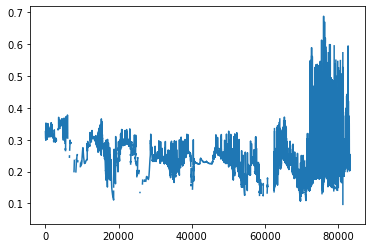

In [11]:
smois_obs.correctedVSWCMean_501.plot(x='date')

### Calculate Daily Average for Observation

In [12]:
# calculate daily average for observation:

df_obs_daily = smois_obs.groupby(['year','month','day']).mean().reset_index()
df_obs_daily['time']=pd.to_datetime(df_obs_daily[["year", "month", "day"]])

df_obs_daily.head()

,year,month,day,horizontalPosition,correctedVSWCMean_501,correctedVSWCMean_502,correctedVSWCMean_503,correctedVSWCMean_504,correctedVSWCMean_505,correctedVSWCMean_506,...,correctedVSWCExpUncert_505,correctedVSWCExpUncert_506,correctedVSWCExpUncert_507,correctedVSWCExpUncert_508,wtAve0to1m,wtAveMLs,wtAve0to1m_consistentMLs,wtAveMLs_consistentMLs,hour,time
0,2017,8,1,5.0,0.314690,0.349630,0.316962,0.191510,0.309946,0.369415,...,NaN,NaN,NaN,NaN,0.303761,31155.131579,0.302892,123456.0,11.5,2017-08-01
1,2017,8,2,5.0,0.303595,0.345275,0.314739,0.189681,0.307538,0.368746,...,NaN,NaN,NaN,NaN,0.301700,37137.388889,0.299609,123456.0,11.5,2017-08-02
2,2017,8,3,5.0,0.314656,0.345798,0.313016,0.187131,0.310606,0.368121,...,NaN,NaN,NaN,NaN,0.305788,9482.406250,0.297806,123456.0,11.5,2017-08-03
3,2017,8,4,5.0,0.331329,0.354044,0.316754,0.190851,0.330538,0.367706,...,NaN,NaN,NaN,NaN,0.319095,11057.054054,0.304035,123456.0,11.5,2017-08-04
4,2017,8,5,5.0,0.320469,0.352488,0.317482,0.192236,0.307032,0.367648,...,NaN,NaN,NaN,NaN,0.298891,23954.500000,0.303004,123456.0,11.5,2017-08-05


quickly inspect a variable:

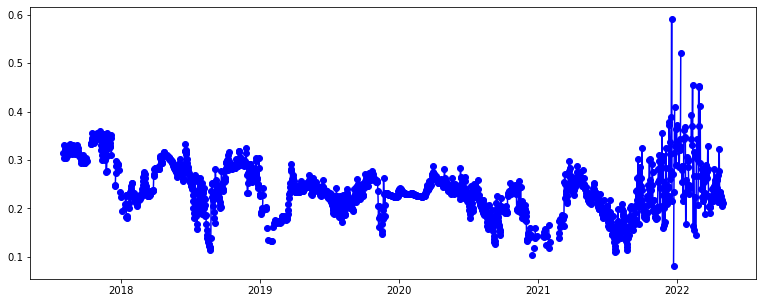

In [13]:
plot_var = 'correctedVSWCMean_501'
plt.figure(num=None, figsize=(13, 5),  facecolor='w', edgecolor='k')

plt.plot ( df_obs_daily.time, df_obs_daily[plot_var], marker = 'o' , color = 'b',label="NEON")

Plot shows data for out of our years range so filter data for our range of years. 

In [14]:
# -- select only data whithin our range of years
df_obs_daily = df_obs_daily[df_obs_daily['year'].isin(years)]

In [15]:
df_obs_daily.head()

,year,month,day,horizontalPosition,correctedVSWCMean_501,correctedVSWCMean_502,correctedVSWCMean_503,correctedVSWCMean_504,correctedVSWCMean_505,correctedVSWCMean_506,...,correctedVSWCExpUncert_505,correctedVSWCExpUncert_506,correctedVSWCExpUncert_507,correctedVSWCExpUncert_508,wtAve0to1m,wtAveMLs,wtAve0to1m_consistentMLs,wtAveMLs_consistentMLs,hour,time
153,2018,1,1,5.0,NaN,0.326810,0.323757,0.198880,0.294668,0.377006,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,123456.0,11.5,2018-01-01
154,2018,1,2,5.0,0.195299,NaN,0.322042,0.197156,0.293758,0.376064,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,123456.0,11.5,2018-01-02
155,2018,1,3,5.0,NaN,0.322377,0.321085,0.195896,0.292751,0.375247,...,NaN,NaN,NaN,NaN,0.304241,1487.833333,NaN,123456.0,11.5,2018-01-03
156,2018,1,4,5.0,NaN,0.322727,0.320901,0.195403,0.292234,0.373828,...,NaN,NaN,NaN,NaN,0.300551,6032.153846,NaN,123456.0,11.5,2018-01-04
157,2018,1,5,5.0,NaN,0.322001,0.320355,0.194680,0.291857,0.373007,...,NaN,NaN,NaN,NaN,0.303979,8108.818182,NaN,123456.0,11.5,2018-01-05


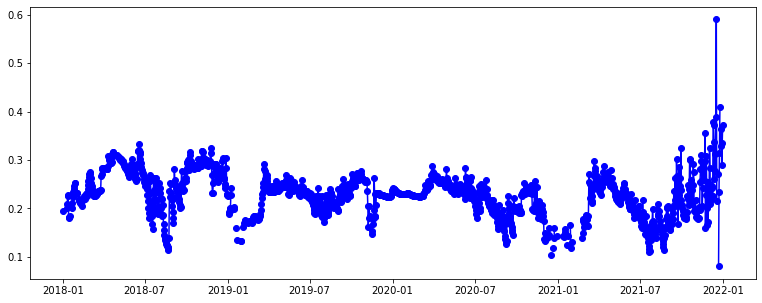

In [16]:
plot_var = 'correctedVSWCMean_501'
plt.figure(num=None, figsize=(13, 5),  facecolor='w', edgecolor='k')

plt.plot ( df_obs_daily.time, df_obs_daily[plot_var], marker = 'o' , color = 'b',label="NEON")

In [17]:
plot_vars = ['correctedVSWCMean_501','correctedVSWCMean_502','correctedVSWCMean_503',
             'correctedVSWCMean_504','correctedVSWCMean_505','correctedVSWCMean_506',
             'correctedVSWCMean_507','correctedVSWCMean_508',]

<AxesSubplot:xlabel='time'>

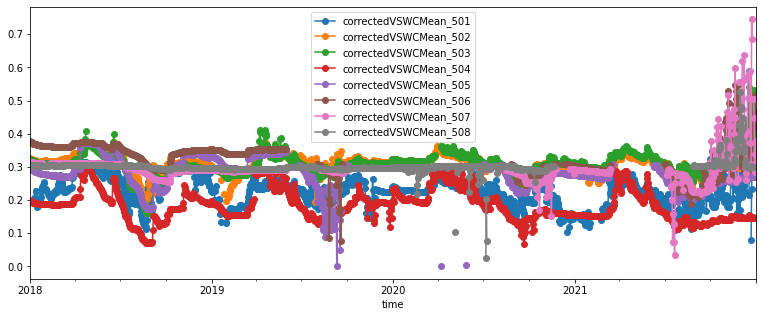

In [18]:
plt.figure(num=None, figsize=(13, 5),  facecolor='w', edgecolor='k')
ax = plt.gca()

df_obs_daily.plot(x= 'time', y= plot_vars , marker = 'o', ax = ax )

_________________
# 2- Read simulation files

In [19]:
#sim_path = "/glade/scratch/negins/neon_v2/tools/site_and_regional/archive/"+neon_site+".transient/lnd/hist/"
sim_path = "/glade/scratch/wwieder/NEON_testV2/archive/"+neon_site+".transient/lnd/hist/"

sim_files = []
for year in years:
    sim_files.extend(sorted(glob(join(sim_path,neon_site+".transient.clm2.h1."+str(year)+"*.nc"))))


print("All Simulation files for all years: [", len(sim_files), "files]")

All Simulation files for all years: [ 1461 files]


Pre-process function to only read in H2OSOI:

In [20]:
def preprocess (ds):
    variables = ['H2OSOI']

    ds_new= ds[variables]
    return ds_new

In [21]:
print ("Start reading v2 simulation data:")
start = time.time()

ds_ctsm = xr.open_mfdataset(sim_files, decode_times=True, combine='by_coords',parallel=True, preprocess=preprocess)

end = time.time()
print("Reading all simulation files took:", end-start, "s.")

Start reading v2 simulation data:
Reading all simulation files took: 13.417470693588257 s.


Quickly inspect H2OSOI at level 0 (top level).

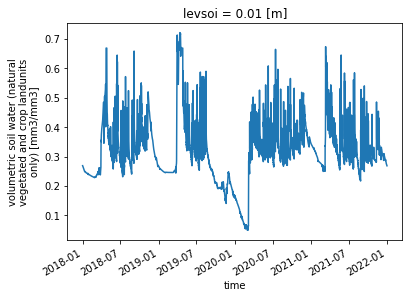

In [22]:
ds_ctsm.H2OSOI.isel(levsoi= 0).plot()

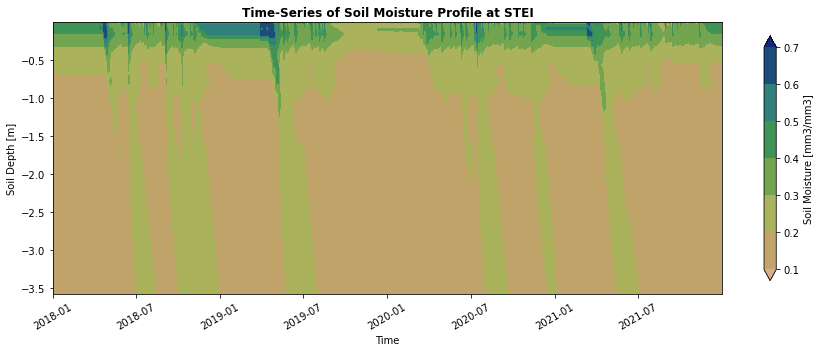

In [23]:
var='H2OSOI'
h2o_soi = ds_ctsm[var].isel(levsoi=(slice(0,15)))
x= h2o_soi.time.values
y= -h2o_soi.levsoi.values
plot_var =  h2o_soi[:,:,0].values.transpose()

#cmap = 'viridis'
var_name = 'Soil Moisture'
var_unit = '[mm3/mm3]'
#ds_ctsm[var].isel(levsoi=(slice(0,15))).plot(x="time",yincrease=False, robust=True,cmap='viridis',figsize=(15, 5))
cmap = plt.get_cmap('gist_earth_r')
cmap = truncate_colormap(cmap, 0.15, 0.9)

X, Y = np.meshgrid(x, y)


fig= plt.figure(num=None, figsize=(15,5),  facecolor='w', edgecolor='k')

ax = plt.gca()
cs = ax.contourf(X, Y, plot_var,cmap=cmap,extend="both")
plt.xticks(rotation=30)
plt.ylabel('Soil Depth [m]')
plt.xlabel('Time')
plt.title ('Time-Series of '+ var_name +' Profile at '+neon_site,fontweight="bold")
cbar = fig.colorbar(cs, ax=ax, shrink=0.9)
y_label = var_name +' '+var_unit
cbar.ax.set_ylabel(y_label)

plt.show()

___________________

# 3-  Read soil layer information:

In [24]:
soil_depth_file = '/glade/scratch/negins/soil_depth.csv'
soil_data = pd.read_csv(soil_depth_file)
soil_data.head()

,domainID,siteID,horizontalPosition.HOR,verticalPosition.VER,sensorDepth,startDateTime,endDateTime
0,D01,BART,1,501,-0.06,2010-01-01T00:00:00Z,NaN
1,D01,BART,1,502,-0.16,2010-01-01T00:00:00Z,NaN
2,D01,BART,1,503,-0.26,2010-01-01T00:00:00Z,NaN
3,D01,BART,1,504,-0.56,2010-01-01T00:00:00Z,NaN
4,D01,BART,1,505,-0.96,2010-01-01T00:00:00Z,NaN


In [25]:
#-- select ABBY data
soil_data = soil_data[soil_data['siteID']==neon_site]
soil_data.head()

,domainID,siteID,horizontalPosition.HOR,verticalPosition.VER,sensorDepth,startDateTime,endDateTime
401,D05,STEI,1,501,-0.063,2010-01-01T00:00:00Z,NaN
402,D05,STEI,1,502,-0.163,2010-01-01T00:00:00Z,NaN
403,D05,STEI,1,503,-0.263,2010-01-01T00:00:00Z,NaN
404,D05,STEI,1,504,-0.463,2010-01-01T00:00:00Z,NaN
405,D05,STEI,1,505,-0.663,2010-01-01T00:00:00Z,NaN


In [26]:
plot_var = 'correctedVSWCMean_501'
ver = int(plot_var[-3:])
print (ver)

501


In [27]:
soil_data.loc[soil_data['verticalPosition.VER'] == ver]

,domainID,siteID,horizontalPosition.HOR,verticalPosition.VER,sensorDepth,startDateTime,endDateTime
401,D05,STEI,1,501,-0.063,2010-01-01T00:00:00Z,NaN
409,D05,STEI,2,501,-0.065,2010-01-01T00:00:00Z,NaN
417,D05,STEI,3,501,-0.060,2010-01-01T00:00:00Z,NaN
425,D05,STEI,4,501,-0.070,2010-01-01T00:00:00Z,NaN
433,D05,STEI,5,501,-0.063,2010-01-01T00:00:00Z,NaN


## Question:
What is the horizontal position? Multiple depth for the same site and sensor id


In [28]:
# -- choose the first depth for now:
sensor_depth = soil_data.loc[soil_data['verticalPosition.VER'] == ver, 'sensorDepth'].iloc[0]
print (sensor_depth)

# -- convert to positive
sensor_depth = np.abs(sensor_depth)
print (sensor_depth)


-0.063
0.063


_________________________________
## select model layers for the depth

In [29]:
ds_ctsm.H2OSOI.levsoi

<xarray.DataArray 'levsoi' (levsoi: 20)>
array([0.01, 0.04, 0.09, 0.16, 0.26, 0.4 , 0.58, 0.8 , 1.06, 1.36, 1.7 , 2.08,
       2.5 , 2.99, 3.58, 4.27, 5.06, 5.95, 6.94, 8.03], dtype=float32)
Coordinates:
  * levsoi   (levsoi) float32 0.01 0.04 0.09 0.16 0.26 ... 5.06 5.95 6.94 8.03
Attributes:
    long_name:  coordinate soil levels (equivalent to top nlevsoi levels of l...
    units:      m

In [30]:
this_layer= ds_ctsm.H2OSOI.sel(levsoi= sensor_depth , method = 'nearest')

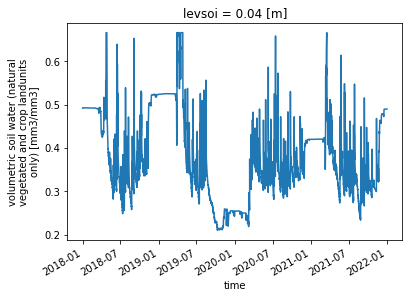

In [31]:
this_layer.plot()

In [32]:
this_layer.levsoi.values

array(0.04, dtype=float32)

In [33]:
ds_ctsm.levsoi.where((ds_ctsm.levsoi== 0.09), drop='True')

<xarray.DataArray 'levsoi' (levsoi: 1)>
array([0.09], dtype=float32)
Coordinates:
  * levsoi   (levsoi) float32 0.09
Attributes:
    long_name:  coordinate soil levels (equivalent to top nlevsoi levels of l...
    units:      m

Quickly inspect all data:

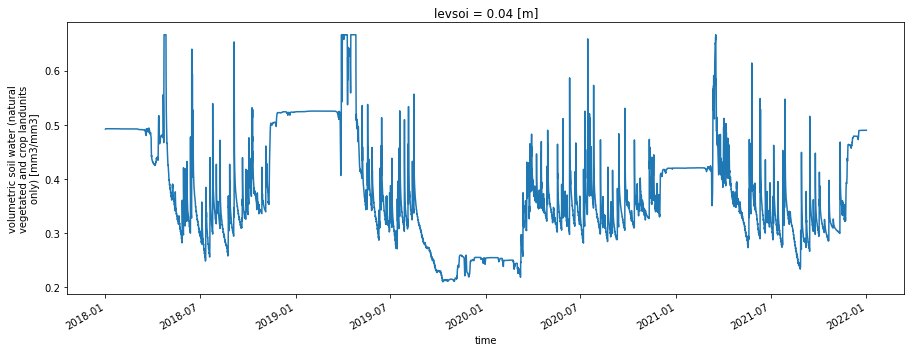

In [34]:
fig= plt.figure(num=None, figsize=(15,5),  facecolor='w', edgecolor='k')

ax = plt.gca()
this_layer.plot(ax= ax)

### Calculate Daily Average for Simulation Files

In [35]:
#Convert CTSM data to a Pandas Dataframe for easier handling:
ctsm_vars = ['H2OSOI']

df_ctsm = pd.DataFrame({'time':this_layer.time})

for var in ctsm_vars:
    field = np.ravel ( this_layer.values)     
    df_ctsm[var]=field


df_ctsm['year'] = df_ctsm['time'].dt.year
df_ctsm['month'] = df_ctsm['time'].dt.month
df_ctsm['day'] = df_ctsm['time'].dt.day
df_ctsm['hour'] = df_ctsm['time'].dt.hour


df_ctsm_daily = df_ctsm.groupby(['year','month','day']).mean().reset_index()
df_ctsm_daily['time']=pd.to_datetime(df_ctsm_daily[["year", "month", "day"]])

df_ctsm_daily.head()

,year,month,day,H2OSOI,hour,time
0,2018,1,1,0.492648,11.354167,2018-01-01
1,2018,1,2,0.492783,11.333333,2018-01-02
2,2018,1,3,0.492783,11.333333,2018-01-03
3,2018,1,4,0.492783,11.333333,2018-01-04
4,2018,1,5,0.492783,11.333333,2018-01-05


Now let's plot daily averages:

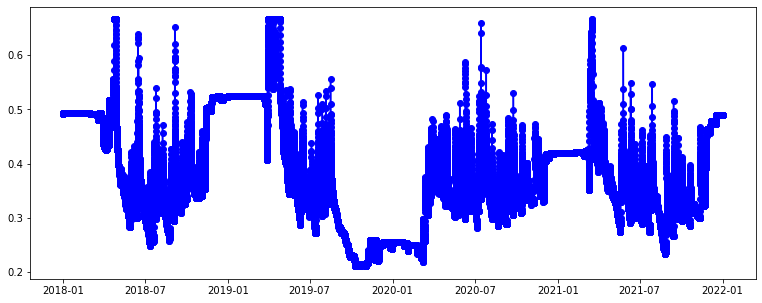

In [36]:
plot_var = 'H2OSOI'
plt.figure(num=None, figsize=(13, 5),  facecolor='w', edgecolor='k')

plt.plot ( df_ctsm.time, df_ctsm[plot_var], marker = 'o' , color = 'b',label="CLM")

----------
## Check daily average data created
Now we have 2 pandas dataframe that includes daily averages.

In [37]:
df_ctsm_daily

,year,month,day,H2OSOI,hour,time
0,2018,1,1,0.492648,11.354167,2018-01-01
1,2018,1,2,0.492783,11.333333,2018-01-02
2,2018,1,3,0.492783,11.333333,2018-01-03
3,2018,1,4,0.492783,11.333333,2018-01-04
4,2018,1,5,0.492783,11.333333,2018-01-05
...,...,...,...,...,...,...
1456,2021,12,27,0.489889,11.333333,2021-12-27
1457,2021,12,28,0.489908,11.333333,2021-12-28
1458,2021,12,29,0.489927,11.333333,2021-12-29
1459,2021,12,30,0.489927,11.333333,2021-12-30


In [38]:
df_obs_daily

,year,month,day,horizontalPosition,correctedVSWCMean_501,correctedVSWCMean_502,correctedVSWCMean_503,correctedVSWCMean_504,correctedVSWCMean_505,correctedVSWCMean_506,...,correctedVSWCExpUncert_505,correctedVSWCExpUncert_506,correctedVSWCExpUncert_507,correctedVSWCExpUncert_508,wtAve0to1m,wtAveMLs,wtAve0to1m_consistentMLs,wtAveMLs_consistentMLs,hour,time
153,2018,1,1,5.0,NaN,0.326810,0.323757,0.198880,0.294668,0.377006,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,123456.0,11.5,2018-01-01
154,2018,1,2,5.0,0.195299,NaN,0.322042,0.197156,0.293758,0.376064,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,123456.0,11.5,2018-01-02
155,2018,1,3,5.0,NaN,0.322377,0.321085,0.195896,0.292751,0.375247,...,NaN,NaN,NaN,NaN,0.304241,1487.833333,NaN,123456.0,11.5,2018-01-03
156,2018,1,4,5.0,NaN,0.322727,0.320901,0.195403,0.292234,0.373828,...,NaN,NaN,NaN,NaN,0.300551,6032.153846,NaN,123456.0,11.5,2018-01-04
157,2018,1,5,5.0,NaN,0.322001,0.320355,0.194680,0.291857,0.373007,...,NaN,NaN,NaN,NaN,0.303979,8108.818182,NaN,123456.0,11.5,2018-01-05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1609,2021,12,27,5.0,0.328601,0.297448,0.530664,0.147215,0.270136,0.461078,...,NaN,NaN,NaN,NaN,0.248005,245.000000,NaN,123456.0,11.5,2021-12-27
1610,2021,12,28,5.0,0.365028,0.298523,0.428792,0.146947,0.269889,0.435435,...,NaN,NaN,NaN,NaN,NaN,245.000000,NaN,123456.0,11.5,2021-12-28
1611,2021,12,29,5.0,0.290121,0.298877,0.370527,0.147050,0.269713,0.417322,...,NaN,NaN,NaN,NaN,NaN,245.000000,NaN,123456.0,11.5,2021-12-29
1612,2021,12,30,5.0,0.334513,0.299027,0.398235,0.146942,0.269625,0.517281,...,NaN,NaN,NaN,NaN,0.248264,245.000000,NaN,123456.0,11.5,2021-12-30


Quickly plot top level model soil moisture and observation:

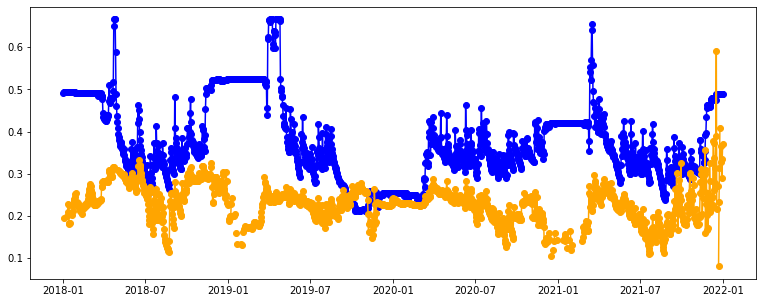

In [39]:
plot_var = 'H2OSOI'
plt.figure(num=None, figsize=(13, 5),  facecolor='w', edgecolor='k')

plt.plot ( df_ctsm_daily.time, df_ctsm_daily[plot_var], marker = 'o' , color = 'b',label="CLM")
plot_var = 'correctedVSWCMean_501'
plt.plot ( df_obs_daily.time, df_obs_daily[plot_var], marker = 'o' , color = 'orange',label="NEON")



_________________
To automate stuff, let's create a dictionary of soil depths:

In [40]:
plot_vars = ['correctedVSWCMean_501','correctedVSWCMean_502','correctedVSWCMean_503',
             'correctedVSWCMean_504','correctedVSWCMean_505','correctedVSWCMean_506',
             'correctedVSWCMean_507','correctedVSWCMean_508',]

layers_dict = {}
for pl in plot_vars:
    ver = int(pl[-3:])
    sensor_depth = soil_data.loc[soil_data['verticalPosition.VER'] == ver, 'sensorDepth'].iloc[0]
    sensor_depth = np.abs(sensor_depth)
    layers_dict[pl] = sensor_depth
    
print (layers_dict)


{'correctedVSWCMean_501': 0.063, 'correctedVSWCMean_502': 0.163, 'correctedVSWCMean_503': 0.263, 'correctedVSWCMean_504': 0.463, 'correctedVSWCMean_505': 0.663, 'correctedVSWCMean_506': 0.963, 'correctedVSWCMean_507': 1.263, 'correctedVSWCMean_508': 1.963}


### Plot selected layers

In [41]:
# -- layers are selected in consulation with Danica and Gordon
plot_vars_selected = [plot_vars[i] for i in [0,3,4,5]]

0it [00:00, ?it/s]

correctedVSWCMean_501
0.063
0.04


1it [00:01,  1.52s/it]

correctedVSWCMean_504
0.463
0.4


2it [00:03,  1.69s/it]

correctedVSWCMean_505
0.663
0.58


3it [00:05,  1.78s/it]

correctedVSWCMean_506
0.963
1.06


4it [00:06,  1.72s/it]


Saving /glade/work/wwieder/neon_vis_plots/paper_plots_final/Fig8/STEI_soil_moisture_tseries_selected_layers.png
Saving /glade/work/wwieder/neon_vis_plots/paper_plots_final/Fig8/STEI_soil_moisture_tseries_selected_layers.pdf


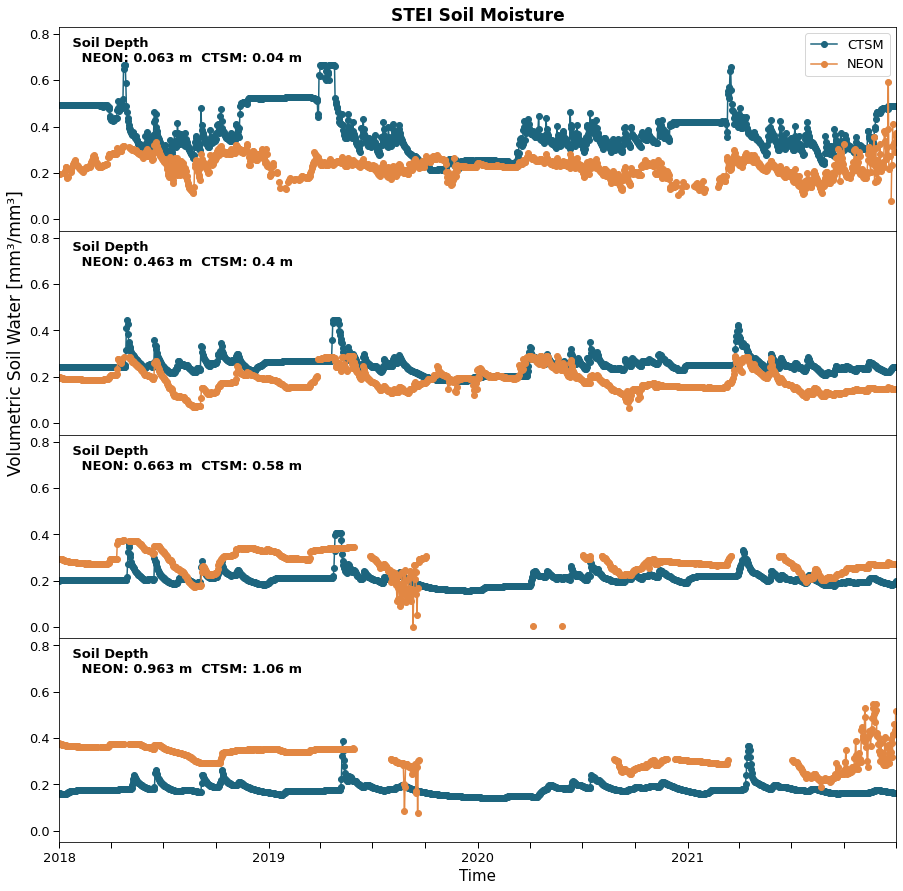

In [42]:
#plot_dir = "/glade/work/negins/neon_vis_plots/paper_plots/"
plot_dir = "/glade/work/wwieder/neon_vis_plots/paper_plots_final/Fig8"
if not os.path.isdir(plot_dir):
    os.makedirs(plot_dir, exist_ok=True)  
        
fig = plt.figure(num=None, figsize=(15, 15),  facecolor='w', edgecolor='k')
axes = fig.subplots(nrows=len(plot_vars_selected), ncols=1)
axe = axes.ravel()

for idx, pl in tqdm.tqdm(enumerate(plot_vars_selected)):
    print (pl)
    this_layer= ds_ctsm.H2OSOI.sel(levsoi= layers_dict[pl] , method = 'nearest')
    ax = axe[idx]
    print (layers_dict[pl])
    print (this_layer.levsoi.values)
    df_ctsm = pd.DataFrame({'time':this_layer.time})

    for var in ctsm_vars:
        field = np.ravel ( this_layer.values)     
        df_ctsm[var]=field
        
        
    df_ctsm['year'] = df_ctsm['time'].dt.year
    df_ctsm['month'] = df_ctsm['time'].dt.month
    df_ctsm['day'] = df_ctsm['time'].dt.day
    df_ctsm['hour'] = df_ctsm['time'].dt.hour
    
    
    df_ctsm_daily = df_ctsm.groupby(['year','month','day']).mean().reset_index()
    df_ctsm_daily['time']=pd.to_datetime(df_ctsm_daily[["year", "month", "day"]])
    
    color1= '#e28743'
    color2='#1d657e'
    
    df_ctsm_daily.plot ( x='time', y='H2OSOI', marker = 'o' , color = color2,label="CTSM", ax = ax)
    
    df_obs_daily.plot ( x='time', y=pl, marker = 'o' , color = color1,label="NEON", ax = ax)
    ax.tick_params(axis='both', which='both', labelsize=13,width=1,length=6)
    #
    #ax.tick_params(axis='x',which = 'both', direction="in")
    #ax.tick_params(axis='x',which = 'major', direction="in")

    ax.set_ylim(-0.05, 0.83)
    depth_text = ' Soil Depth \n '+ \
                  '  NEON: '+ str(layers_dict[pl])+' m'+ \
                  '  CTSM: ' + str(this_layer.levsoi.values) +' m'
    #ax.text(.015,0.9,'Soil Depth : '+ str(layers_dict[pl])+' m',
    #        horizontalalignment='left',
    #        transform=ax.transAxes, fontweight='bold',fontsize=13)
    ax.text(.01,0.83,depth_text,
            horizontalalignment='left',
            transform=ax.transAxes, fontweight='bold',fontsize=13)
    
    if idx != len(plot_vars_selected)-1:
        ax.set_xticks([])
    else:
        ax.set_xlabel('Time', fontsize=15)

        
    if idx == 0:
        ax.legend(fontsize = 13)
        ax.set_title(neon_site + ' Soil Moisture', fontweight='bold',fontsize=17)

    else:
        ax.get_legend().remove()
    fig.subplots_adjust(wspace=0, hspace=0)
    
    if idx ==1:
        plot_var_desc = 'Volumetric Soil Water'
        plot_var_unit = 'mm³/mm³'
        ax.set_ylabel(plot_var_desc+" ["+plot_var_unit+"]", fontsize=17)

plot_name = neon_site + '_soil_moisture_tseries_selected_layers.png'
print ('Saving '+ os.path.join(plot_dir,plot_name))    
plt.savefig (os.path.join(plot_dir,plot_name), dpi=300,bbox_inches='tight')

plot_name = neon_site + '_soil_moisture_tseries_selected_layers.pdf'
print ('Saving '+ os.path.join(plot_dir,plot_name))    
plt.savefig (os.path.join(plot_dir,plot_name), dpi=300,bbox_inches='tight')
plt.show()


## Plot all soil layers

0it [00:00, ?it/s]

correctedVSWCMean_501
0.063
0.04


1it [00:01,  1.85s/it]

correctedVSWCMean_502
0.163
0.16


2it [00:03,  1.92s/it]

correctedVSWCMean_503
0.263
0.26


3it [00:05,  1.80s/it]

correctedVSWCMean_504
0.463
0.4


4it [00:07,  1.86s/it]

correctedVSWCMean_505
0.663
0.58


5it [00:09,  1.78s/it]

correctedVSWCMean_506
0.963
1.06


6it [00:11,  1.86s/it]

correctedVSWCMean_507
1.263
1.36


7it [00:12,  1.82s/it]

correctedVSWCMean_508
1.963
2.08


8it [00:14,  1.84s/it]


Saving /glade/work/wwieder/neon_vis_plots/paper_plots_final/Fig8/STEI_soil_moisture_tseries_V1.png


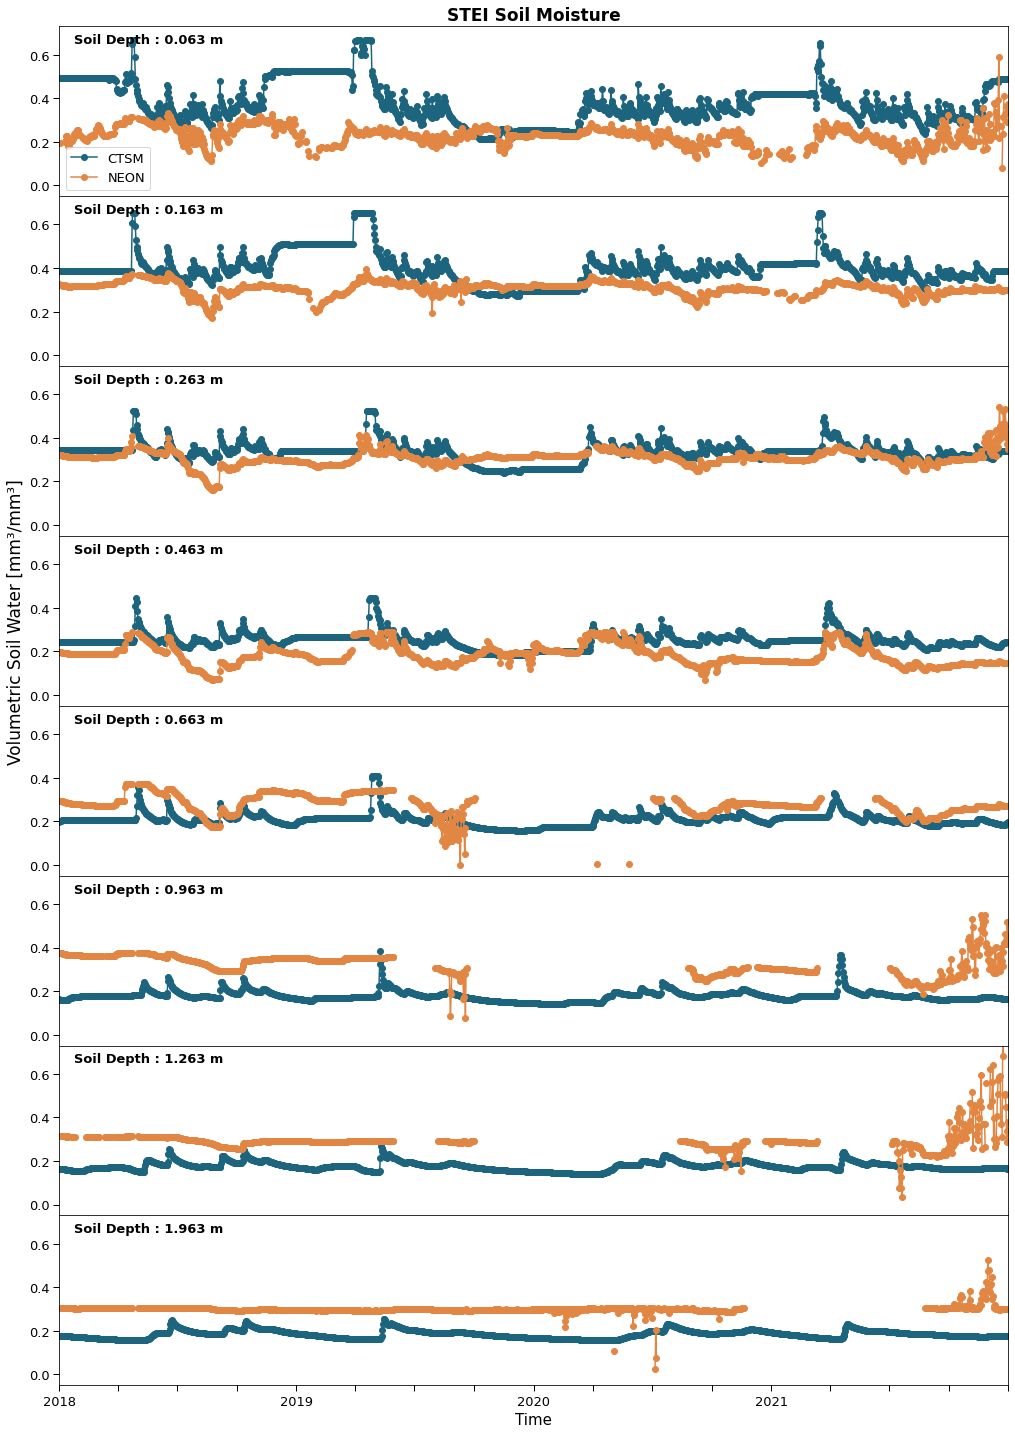

In [43]:
fig = plt.figure(num=None, figsize=(17, 25),  facecolor='w', edgecolor='k')
axes = fig.subplots(nrows=len(plot_vars), ncols=1)
axe = axes.ravel()

for idx, pl in tqdm.tqdm(enumerate(plot_vars)):
    print (pl)
    this_layer= ds_ctsm.H2OSOI.sel(levsoi= layers_dict[pl] , method = 'nearest')
    ax = axe[idx]
    print (layers_dict[pl])
    print (this_layer.levsoi.values)
    df_ctsm = pd.DataFrame({'time':this_layer.time})

    for var in ctsm_vars:
        field = np.ravel ( this_layer.values)     
        df_ctsm[var]=field
        
        
    df_ctsm['year'] = df_ctsm['time'].dt.year
    df_ctsm['month'] = df_ctsm['time'].dt.month
    df_ctsm['day'] = df_ctsm['time'].dt.day
    df_ctsm['hour'] = df_ctsm['time'].dt.hour
    
    
    df_ctsm_daily = df_ctsm.groupby(['year','month','day']).mean().reset_index()
    df_ctsm_daily['time']=pd.to_datetime(df_ctsm_daily[["year", "month", "day"]])
    
    color1='#e28743'
    color2='#1d657e'
    
    df_ctsm_daily.plot ( x='time', y='H2OSOI', marker = 'o' , color = color2,label="CTSM", ax = ax)
    
    df_obs_daily.plot ( x='time', y=pl, marker = 'o' , color = color1,label="NEON", ax = ax)
    ax.tick_params(axis='both', which='both', labelsize=13,width=1,length=6)
    #
    #ax.tick_params(axis='x',which = 'both', direction="in")
    #ax.tick_params(axis='x',which = 'major', direction="in")

    ax.set_ylim(-0.05, 0.73)
    ax.text(.015,0.9,'Soil Depth : '+ str(layers_dict[pl])+' m',
            horizontalalignment='left',
            transform=ax.transAxes, fontweight='bold',fontsize=13)
    
    
    if idx != len(plot_vars)-1:
        ax.set_xticks([])
    else:
        ax.set_xlabel('Time', fontsize=15)

        
    if idx == 0:
        ax.legend(fontsize = 13)
        ax.set_title(neon_site + ' Soil Moisture', fontweight='bold',fontsize=17)

    else:
        ax.get_legend().remove()
    fig.subplots_adjust(wspace=0, hspace=0)
    
    if idx ==3:
        plot_var_desc = 'Volumetric Soil Water'
        plot_var_unit = 'mm³/mm³'
        ax.set_ylabel(plot_var_desc+" ["+plot_var_unit+"]", fontsize=17)

plot_name = neon_site + '_soil_moisture_tseries_V1.png'
print ('Saving '+ os.path.join(plot_dir,plot_name))
plt.savefig (os.path.join(plot_dir,plot_name), dpi=300,bbox_inches='tight')
    
plt.show()
